In [1]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.7 MB/s eta 0:00:0000:01


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, tiktoken, eli5, nltk

from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

import gensim.downloader
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

pd.set_option('display.max_colwidth', None)

2024-05-15 10:10:06.793949: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 10:10:06.794070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 10:10:06.939942: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Pré-traitement

## Unifier les datasets

In [3]:
df = pd.read_csv("/kaggle/input/poems-foundation/our_dataset.csv")
df.drop(df.columns[0], axis=1, inplace=True)

print(f"Numbers of poems: {len(df)}")
df.tail()

Numbers of poems: 10064


,poem,topic
10059,"As the light goes, go. \nBe the rustling in the grass, the fall from \nconvention's good graces: learn, or someone \nwill have you filing files or writing writs, \ndemonstrating cutlery or selling knowledge \n\ndoor to door; someone might even drop \nyour lovely life into a factory and have you \nderusting rings on the coolant-spouting \nturntable of a vertical lathe. \nIt's best for everyone that what you know \n\nis generally thought of as general knowledge. \nYou can find it in pool rooms and roadside bars, \nin meadows as inviting as beds, in bedrooms \nwhere it whispers like a ribbon untying; \nyou can even find it in schools. But be careful: \n\nit's dangerous, inescapable and exact \ndown to every atom of everything there is, \nto every name each thing goes by and every \nlaw each thing obeys. And the best part is, \nyou always know more than you know.",arts&sciences
10060,"Isn't the moon dark too, most of the time? And doesn't the white page seem unfinished without the dark stain of alphabets? When God demanded light, he didn't banish darkness. Instead he invented ebony and crows and that small mole on your left cheekbone. Or did you mean to ask ""Why are you sad so often?"" Ask the moon. Ask what it has witnessed.",arts&sciences
10061,"I imagined the atmosphere would be clear, \nshot with pristine light, \nnot this sulphurous haze, \nthe air ionized as before a thunderstorm. \n\nMany have pictured a river here, \nbut no one mentioned all the boats, \ntheir benches crowded with naked passengers, \neach bent over a writing tablet. \n\nI knew I would not always be a child \nwith a model train and a model tunnel, \nand I knew I would not live forever, \njumping all day through the hoop of myself. \n\nI had heard about the journey to the other side \nand the clink of the final coin \nin the leather purse of the man holding the oar, \nbut how could anyone have guessed \n\nthat as soon as we arrived \nwe would be asked to describe this place \nand to include as much detail as possible— \nnot just the water, he insists, \n\nrather the oily, fathomless, rat-happy water, \nnot simply the shackles, but the rusty, \niron, ankle-shredding shackles— \nand that our next assignment would be \n\nto jot down, off the tops of our heads, \nour thoughts and feelings about being dead, \nnot really an assignment, \nthe man rotating the oar keeps telling us— \n\nthink of it more as an exercise, he groans, \nthink of writing as a process, \na never-ending, infernal process, \nand now the boats have become jammed together, \n\nbow against stern, stern locked to bow, \nand not a thing is moving, only our diligent pens.",arts&sciences
10062,"Miss Nancy Ellicott\nStrode across the hills and broke them,\nRode across the hills and broke them—\nThe barren New England hills—\nRiding to hounds\nOver the cow-pasture.\n\nMiss Nancy Ellicott smoked\nAnd danced all the modern dances;\nAnd her aunts were not quite sure how they felt about it,\nBut they knew that it was modern.\n\nUpon the glazen shelves kept watch\nMatthew and Waldo, guardians of the faith,\nThe army of unalterable law.",arts&sciences
10063,"In the dark we disappear, pure being.\nOur mirror images, impure being.\n\nBeing and becoming (Heidegger), being and\nnothingness (Sartre)—which is purer being?\n\nBeing alone is no way to be: thus\nloneliness is the test of pure being.\n\nNights in love I fell too far or not quite\nfar enough—one pure, one impure being.\n\nClouds, snow, mist, the dragon's breath on water,\nsmoke from fire—a metaphor's pure being.\n\nStillness and more stillness and the light locked\ndeep inside—both pure and impure being.\n\nIs is the verb of being, I the noun—\nor pronoun for the purists of being.\n\nI was, I am, I looked within and saw\nnothing very clearly: purest being.",arts&sciences


## Lowercase, Apostrophes, \r and \n, ponctuations, stop words

In [4]:
# Lowercase
df["poem"] = df["poem"].str.lower()

# Apostrophes
df["poem"] = df["poem"].str.replace("'", "", regex=False)
df["poem"] = df["poem"].str.replace("’", "", regex=False)

# \r and \n (ceux du début)
df["poem"] = df["poem"].str.replace("\r", " ")
df["poem"] = df["poem"].str.strip("\n")
df = df[df["poem"] != ""]

# Ponctuations
df["poem"] = df["poem"].str.replace("[^\w\s]", " ", regex=True)

# Stopwords
stopwords = set(stopwords.words('english'))
df["poem"] = df["poem"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [5]:
df.tail()

,poem,topic
10059,light goes go rustling grass fall conventions good graces learn someone filing files writing writs demonstrating cutlery selling knowledge door door someone might even drop lovely life factory derusting rings coolant spouting turntable vertical lathe best everyone know generally thought general knowledge find pool rooms roadside bars meadows inviting beds bedrooms whispers like ribbon untying even find schools careful dangerous inescapable exact every atom everything every name thing goes every law thing obeys best part always know know,arts&sciences
10060,isnt moon dark time doesnt white page seem unfinished without dark stain alphabets god demanded light didnt banish darkness instead invented ebony crows small mole left cheekbone mean ask sad often ask moon ask witnessed,arts&sciences
10061,imagined atmosphere would clear shot pristine light sulphurous haze air ionized thunderstorm many pictured river one mentioned boats benches crowded naked passengers bent writing tablet knew would always child model train model tunnel knew would live forever jumping day hoop heard journey side clink final coin leather purse man holding oar could anyone guessed soon arrived would asked describe place include much detail possible water insists rather oily fathomless rat happy water simply shackles rusty iron ankle shredding shackles next assignment would jot tops heads thoughts feelings dead really assignment man rotating oar keeps telling us think exercise groans think writing process never ending infernal process boats become jammed together bow stern stern locked bow thing moving diligent pens,arts&sciences
10062,miss nancy ellicott strode across hills broke rode across hills broke barren new england hills riding hounds cow pasture miss nancy ellicott smoked danced modern dances aunts quite sure felt knew modern upon glazen shelves kept watch matthew waldo guardians faith army unalterable law,arts&sciences
10063,dark disappear pure mirror images impure becoming heidegger nothingness sartre purer alone way thus loneliness test pure nights love fell far quite far enough one pure one impure clouds snow mist dragons breath water smoke fire metaphors pure stillness stillness light locked deep inside pure impure verb noun pronoun purists looked within saw nothing clearly purest,arts&sciences


nb poems in topics: 10063


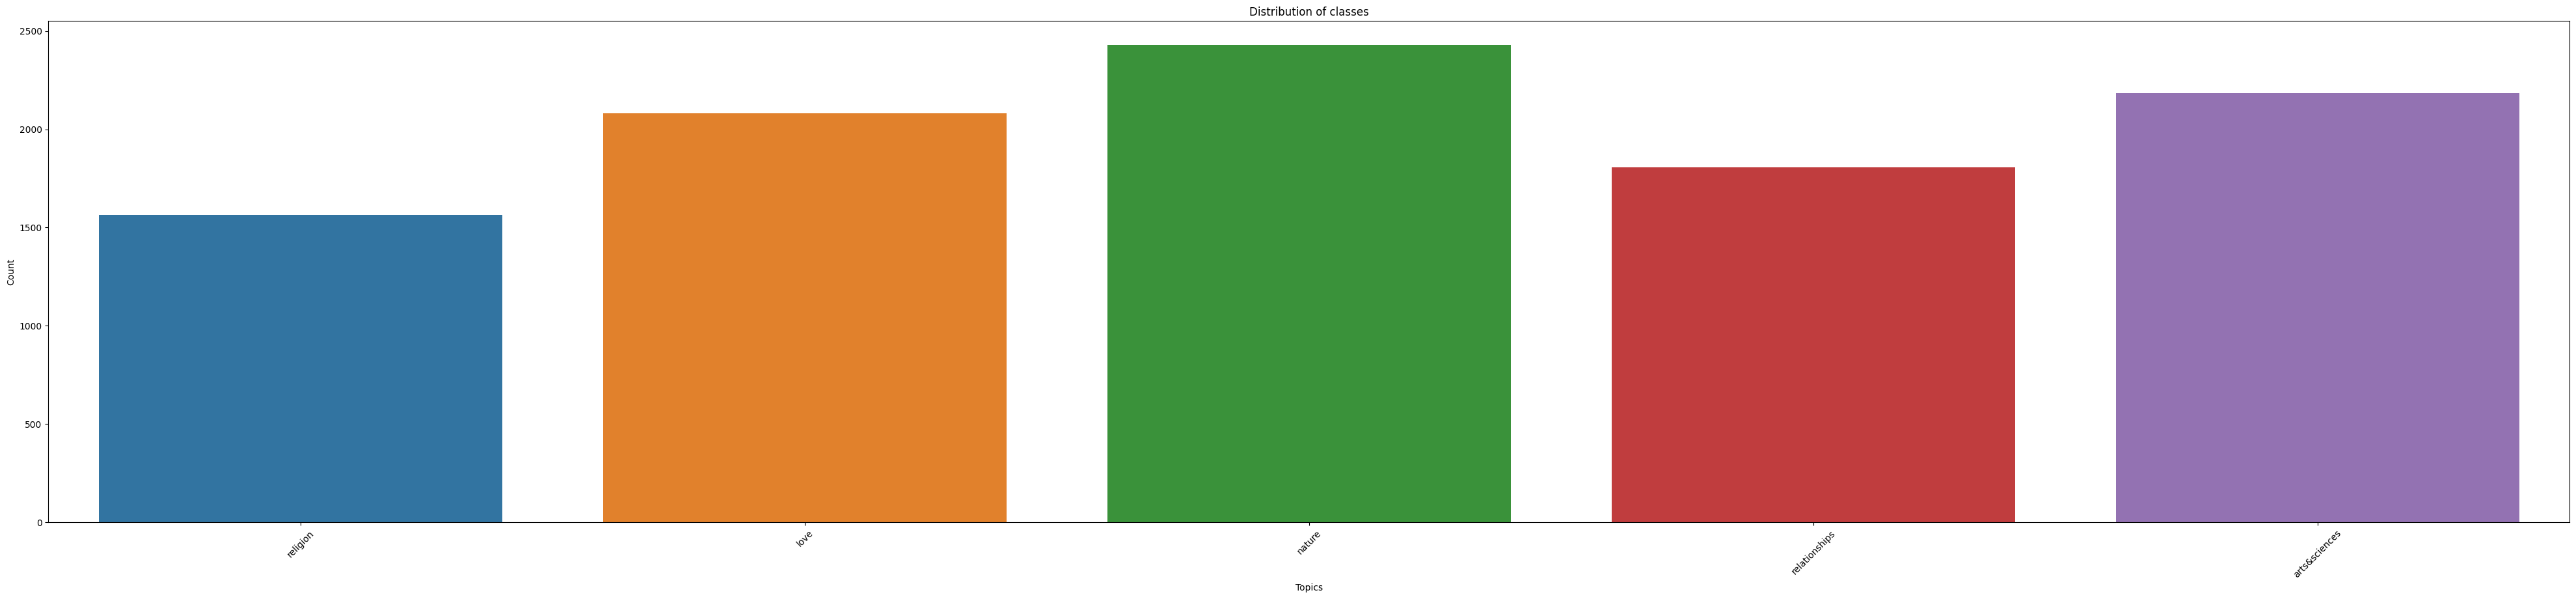

In [6]:
print(f"nb poems in topics: {len(df)}")
#print(f"nb poems in poetry foundation: {len(df_PoetryFoundationData)}")

plt.figure(figsize=(50, 10))
sns.countplot(x='topic', data=df)
plt.title('Distribution of classes') 
plt.xlabel('Topics')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Model & Fitting

## Training Word2vec

In [7]:
X_list = list(df["poem"])
X_strings = " ".join(X_list)
X_sents = sent_tokenize(X_strings)
X_sents = [word_tokenize(s) for s in X_sents]

In [8]:
model = Word2Vec(sentences=X_sents, vector_size=50, window=5, min_count=5, workers=4)

word_vectors = model.wv
word_vectors.save("word2vec.wordvectors") # Store the words and their trained embeddings
del model

In [9]:
wv = KeyedVectors.load("/kaggle/working/word2vec.wordvectors", mmap='r')
sims = wv.most_similar('racist', topn=10)
sims

[('ecbatan', 0.521025538444519),
 ('geode', 0.5111651420593262),
 ('idaho', 0.48426416516304016),
 ('captive', 0.4829387962818146),
 ('appen', 0.47747573256492615),
 ('province', 0.46127766370773315),
 ('tendencies', 0.4570419192314148),
 ('confluence', 0.45417577028274536),
 ('apartments', 0.45074713230133057),
 ('mallet', 0.4469561278820038)]

## Load pretrained Word2vec models

In [10]:
pretrained_wv = gensim.downloader.load('glove-twitter-100')
pretrained_wv

[==================================================] 100.0% 387.1/387.1MB downloaded


In [11]:
def document_vector(doc, wv):
    """Create document vectors by averaging word vectors."""
    words = word_tokenize(doc)
    word_vectors = np.array([wv[word] for word in words if word in wv])
    
    if len(word_vectors) == 0:
        return np.zeros(wv.vector_size)
    return np.mean(word_vectors, axis=0)

In [12]:
document_vector("hello i'm christophe", wv)

array([-0.01989442, -0.01342   , -0.00896213, -0.01469811, -0.01964118,
        0.0122513 ,  0.0100096 ,  0.01803327, -0.00420639,  0.00160003,
       -0.00971204, -0.01328335, -0.01818722, -0.00305205,  0.00676633,
       -0.01448598, -0.00482173, -0.01697531,  0.01826256, -0.01821493,
       -0.00359166, -0.00526289, -0.01302975, -0.01925655, -0.00034026,
       -0.00943078, -0.0017261 ,  0.00396778,  0.00667585, -0.0074546 ,
        0.0157806 ,  0.00667122,  0.01971617,  0.01417927,  0.01119391,
       -0.01941987, -0.00240202,  0.01182048,  0.0057089 , -0.00023093,
        0.00200084,  0.01148549,  0.01143527, -0.00200466,  0.00065512,
       -0.01811429, -0.00842411,  0.01938461, -0.01943489, -0.0112413 ],
      dtype=float32)

In [13]:
document_vector("hello i'm christophe", pretrained_wv)

array([ 4.4119954e-02,  2.5914997e-02, -3.8342491e-02,  3.0954498e-01,
       -3.0992025e-01, -2.3509499e-02,  2.0824239e-02, -8.4839255e-02,
       -1.6701874e-01, -3.3749938e-03, -1.9882837e-01, -9.5597506e-02,
       -3.2976999e+00, -6.1912499e-02, -9.5575005e-03, -1.5902502e-02,
        1.8393874e-01, -1.5495598e-01, -5.3045750e-01,  1.3674751e-01,
        2.2683750e-01, -6.3893849e-01, -6.3707024e-02, -3.6285251e-01,
        1.0785875e-01, -5.4867005e-01,  7.6076999e-02,  2.0618749e-01,
        1.6749749e-01, -3.3292753e-01, -2.5459999e-01, -1.9787498e-02,
       -5.2626401e-01, -1.7145249e-01,  1.5125014e-03,  2.8741848e-01,
       -1.6669600e-01,  2.1532748e-02,  4.0824500e-01,  1.7912501e-01,
       -9.5565754e-01, -4.5286249e-02,  1.3977000e-01,  2.7618325e-01,
       -1.1679300e-01,  7.7807501e-02,  1.9218500e-01, -6.1196005e-01,
       -2.7362242e-01,  1.3037500e-01, -1.7370252e-01,  1.3678105e-01,
       -1.0798100e-01, -3.0793700e-01,  1.2054753e-01,  1.4523749e-01,
      

In [14]:
X = df['poem']
y = df['topic']

label_encoder = LabelEncoder()
classes = np.array(y.values)

integer_encoded = label_encoder.fit_transform(classes) # Transform classes to integers

In [15]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

X_tensor = torch.tensor(X.toarray(), dtype=torch.float32)
y_tensor = torch.tensor(integer_encoded, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(vocab_size, num_classes)
    
    def forward(self, x):
        return self.linear(x)

class MultiLayerPerceptron(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class MultiLayerPerceptron2(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes):
        super(MultiLayerPerceptron2, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim*2)
        self.dropout1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

num_epochs = 100
vocab_size = X_tensor.shape[1]
num_classes = len(set(y.values))

model = LogisticRegressionModel(vocab_size, num_classes)
print(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.float()
        labels = labels.long()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels)
            all_predictions.extend(predicted)

    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

LogisticRegressionModel(
  (linear): Linear(in_features=99201, out_features=5, bias=True)
)
Epoch [1/20], Loss: 1.5126
Precision: 0.5837, Recall: 0.4888, F1 Score: 0.4542
Epoch [2/20], Loss: 1.2352
Precision: 0.5573, Recall: 0.5037, F1 Score: 0.4897
Epoch [3/20], Loss: 1.0084
Precision: 0.5617, Recall: 0.5206, F1 Score: 0.5108
Epoch [4/20], Loss: 0.8071
Precision: 0.5540, Recall: 0.5271, F1 Score: 0.5196
Epoch [5/20], Loss: 0.7651
Precision: 0.5533, Recall: 0.5310, F1 Score: 0.5251
Epoch [6/20], Loss: 0.6101
Precision: 0.5496, Recall: 0.5296, F1 Score: 0.5232
Epoch [7/20], Loss: 0.4846
Precision: 0.5399, Recall: 0.5231, F1 Score: 0.5182
Epoch [8/20], Loss: 0.4597
Precision: 0.5441, Recall: 0.5261, F1 Score: 0.5221
Epoch [9/20], Loss: 0.3303
Precision: 0.5363, Recall: 0.5231, F1 Score: 0.5189
Epoch [10/20], Loss: 0.2987
Precision: 0.5391, Recall: 0.5211, F1 Score: 0.5170
Epoch [11/20], Loss: 0.3466
Precision: 0.5369, Recall: 0.5201, F1 Score: 0.5165
Epoch [12/20], Loss: 0.2923
Precision

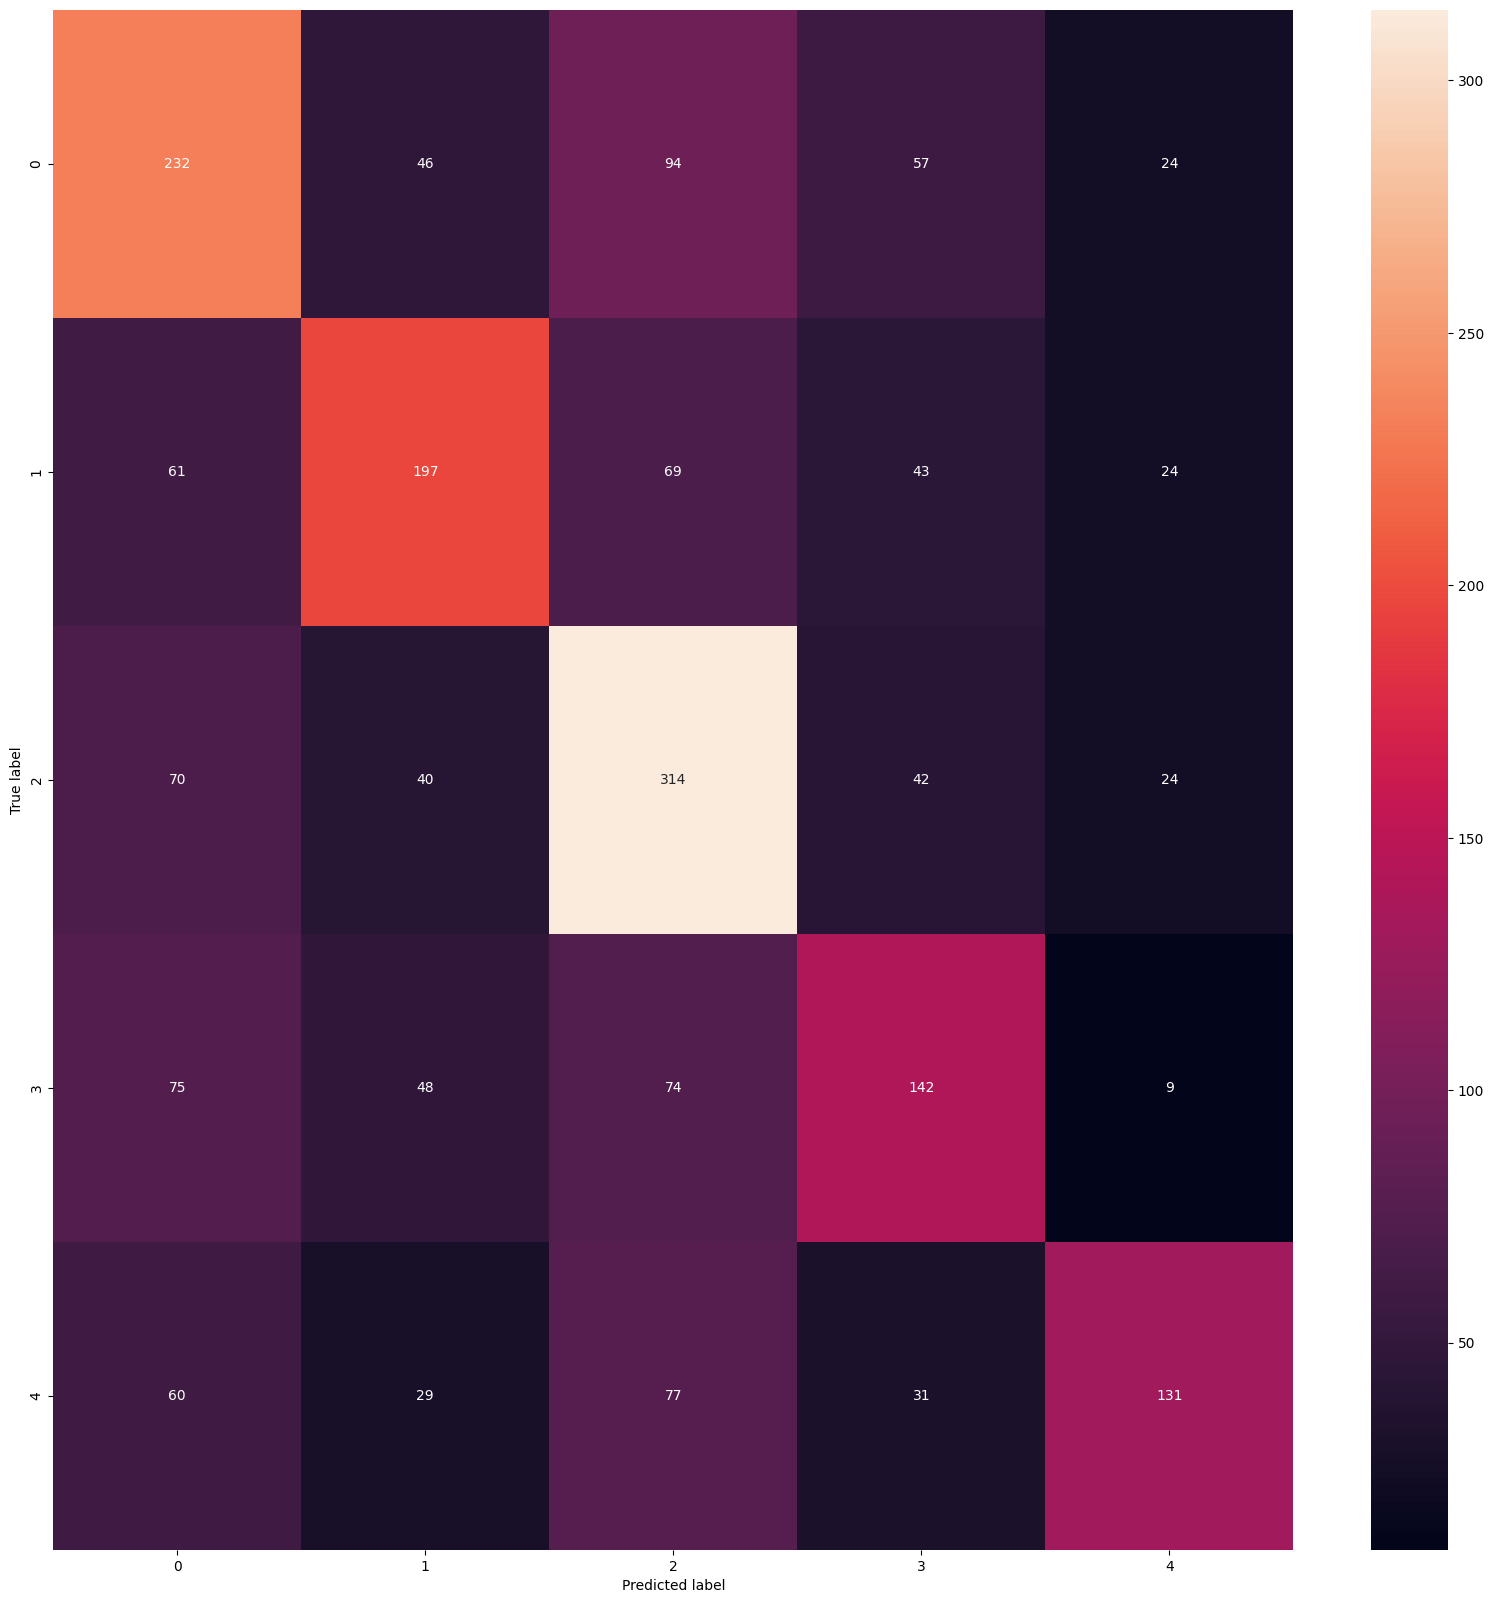

In [17]:
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [18]:
class_names = list(set(y.values))
report = classification_report(all_labels, all_predictions, target_names=class_names)

accuracy = accuracy_score(all_labels, all_predictions)

print("Score de précision :", accuracy)
print("Rapport de classification :\n", report)

Score de précision : 0.5047193243914555
Rapport de classification :
                precision    recall  f1-score   support

relationships       0.47      0.51      0.49       453
arts&sciences       0.55      0.50      0.52       394
       nature       0.50      0.64      0.56       490
         love       0.45      0.41      0.43       348
     religion       0.62      0.40      0.49       328

     accuracy                           0.50      2013
    macro avg       0.52      0.49      0.50      2013
 weighted avg       0.51      0.50      0.50      2013

